# Amazon Bedrock Model Comparison Framework

## Use Case Background

This notebook demonstrates a systematic comparison framework for evaluating foundation models on Amazon Bedrock. This example was created in response to a common customer scenario:

**Customer Context**: A Solutions Architect working with an enterprise customer who needs to evaluate multiple LLMs for their specific workload requirements. The customer wants to compare models across various dimensions—performance benchmarks, cost structure, and actual inference behavior—before making a procurement decision.

**Framework Purpose**: Provide a reproducible methodology for:
1. Aggregating publicly available benchmark data
2. Running parallel inference tests across multiple models
3. Exporting comparison data for team review
4. Enabling data-driven decision making

### Models Under Comparison

* **Claude Sonnet 4.5** (`us.anthropic.claude-sonnet-4-5-20250929-v1:0`)
* **GPT-OSS 120B** (`openai.gpt-oss-120b-1:0`)

### Important Disclaimers

⚠️ **This notebook presents data for comparison purposes only and does not recommend one model over another.**

⚠️ **Benchmark scores are sourced from official vendor documentation and may not reflect your specific use case performance.**

⚠️ **Inference results are examples only. Model performance varies significantly based on prompt engineering, system prompts, and task characteristics.**

⚠️ **Pricing and quotas are subject to change. Verify current AWS pricing before production deployment.**

⚠️ **Always conduct your own evaluation with your specific workload before making decisions.**

## Prerequisites

* Python 3.10+
* AWS credentials with Bedrock access
* Model access enabled for both models
* Sufficient service quotas for parallel inference

In [13]:
!pip install -r requirements.txt --quiet

## Setup

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
import csv
from pathlib import Path
from utils import get_bedrock_client, converse

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Initialize client
bedrock_client = get_bedrock_client(region_name='us-east-1')

# Model configurations
MODELS = {
    'Claude Sonnet 4.5': 'us.anthropic.claude-sonnet-4-5-20250929-v1:0',
    'GPT-OSS 120B': 'openai.gpt-oss-120b-1:0'
}

# Output directory
OUTPUT_DIR = Path('comparison_results')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Framework initialized at {datetime.now().isoformat()}")
print(f"Region: us-east-1")
print(f"Output directory: {OUTPUT_DIR}")

Framework initialized at 2025-11-10T12:16:19.066047
Region: us-east-1
Output directory: comparison_results


## Section 1: Published Benchmark Data

**Data Sources**:
* Claude Sonnet 4.5: Anthropic official documentation (as of model release)
* GPT-OSS 120B: Clarifai/OpenAI documentation (August 2025)

**Note**: These are vendor-published benchmarks. Performance on your specific tasks may differ.

In [ ]:
# Model specifications
specs_data = {
    'Specification': ['Provider', 'Context Window', 'Max Output Tokens'],
    'Claude Sonnet 4.5': ['Anthropic', '200K', '16K'],
    'GPT-OSS 120B': ['OpenAI', '128K', '16K']
}

df_specs = pd.DataFrame(specs_data)
print("\nModel Specifications")
print("="*80)
print(df_specs.to_string(index=False))


Model Specifications
    Specification Claude Sonnet 4.5 GPT-OSS 120B
         Provider         Anthropic       OpenAI
   Context Window              200K         128K
Max Output Tokens               16K          16K
     Architecture             Dense          MoE


In [16]:
# Published benchmark results
benchmark_data = {
    'Benchmark': [
        'SWE-bench Verified',
        'Agentic Coding',
        'AIME 2025',
        'GPQA Diamond',
        'MMLU / MMLU-Pro',
        'Graduate-level Reasoning',
        'TAU-bench Retail'
    ],
    'Claude Sonnet 4.5': [82.0, 77.2, 100.0, 83.4, 89.1, 83.4, 'N/A'],
    'GPT-OSS 120B': [62.4, 'N/A', 97.9, 80.9, 90.0, 80.9, 67.8]
}

df_benchmarks = pd.DataFrame(benchmark_data)
print("\nPublished Benchmark Scores")
print("="*80)
print(df_benchmarks.to_string(index=False))
print("\n⚠️ Scores from vendor documentation. Test conditions may vary.")


Published Benchmark Scores
               Benchmark Claude Sonnet 4.5 GPT-OSS 120B
      SWE-bench Verified              82.0         62.4
          Agentic Coding              77.2          N/A
               AIME 2025             100.0         97.9
            GPQA Diamond              83.4         80.9
         MMLU / MMLU-Pro              89.1         90.0
Graduate-level Reasoning              83.4         80.9
        TAU-bench Retail               N/A         67.8

⚠️ Scores from vendor documentation. Test conditions may vary.


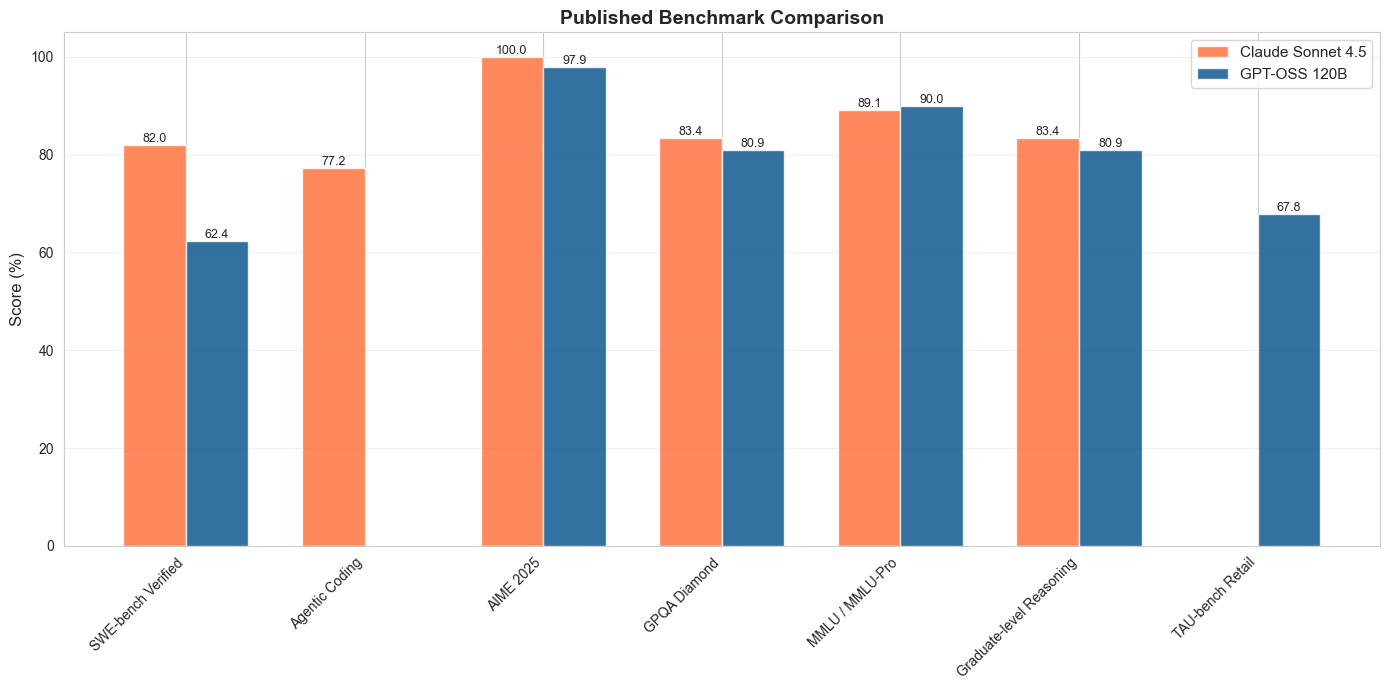

In [17]:
# Visualize benchmarks
df_plot = df_benchmarks.copy()
df_plot['Claude Sonnet 4.5'] = pd.to_numeric(df_plot['Claude Sonnet 4.5'], errors='coerce')
df_plot['GPT-OSS 120B'] = pd.to_numeric(df_plot['GPT-OSS 120B'], errors='coerce')
df_plot = df_plot.fillna(0)

fig, ax = plt.subplots(figsize=(14, 7))
x = range(len(df_plot))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], df_plot['Claude Sonnet 4.5'], width, 
               label='Claude Sonnet 4.5', color='#FF6B35', alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], df_plot['GPT-OSS 120B'], width, 
               label='GPT-OSS 120B', color='#004E89', alpha=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Published Benchmark Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Benchmark'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Section 2: Cost Analysis

**Pricing Source**: AWS Bedrock pricing page (US East Ohio region, as of Nov 2025)

**Note**: This analysis uses example token volumes. Your actual costs will depend on your specific usage patterns.

In [18]:
# Pricing configuration ($/1K tokens)
pricing = {
    'Claude Sonnet 4.5': {'input': 0.003, 'output': 0.015},
    'GPT-OSS 120B': {'input': 0.00015, 'output': 0.0006}
}

# Example usage scenarios
scenarios = [
    {'name': 'Scenario A', 'requests_per_day': 1000, 'avg_input_tokens': 500, 'avg_output_tokens': 300},
    {'name': 'Scenario B', 'requests_per_day': 10000, 'avg_input_tokens': 800, 'avg_output_tokens': 500},
    {'name': 'Scenario C', 'requests_per_day': 50000, 'avg_input_tokens': 1000, 'avg_output_tokens': 800},
    {'name': 'Scenario D', 'requests_per_day': 200000, 'avg_input_tokens': 1200, 'avg_output_tokens': 1000}
]

def calculate_monthly_cost(daily_requests, avg_input, avg_output, input_price, output_price):
    monthly_requests = daily_requests * 30
    input_cost = (monthly_requests * avg_input / 1000) * input_price
    output_cost = (monthly_requests * avg_output / 1000) * output_price
    return input_cost + output_cost

cost_results = []
for scenario in scenarios:
    claude_cost = calculate_monthly_cost(
        scenario['requests_per_day'],
        scenario['avg_input_tokens'],
        scenario['avg_output_tokens'],
        pricing['Claude Sonnet 4.5']['input'],
        pricing['Claude Sonnet 4.5']['output']
    )
    
    gptoss_cost = calculate_monthly_cost(
        scenario['requests_per_day'],
        scenario['avg_input_tokens'],
        scenario['avg_output_tokens'],
        pricing['GPT-OSS 120B']['input'],
        pricing['GPT-OSS 120B']['output']
    )
    
    cost_results.append({
        'Scenario': scenario['name'],
        'Daily Requests': f"{scenario['requests_per_day']:,}",
        'Avg Input Tokens': scenario['avg_input_tokens'],
        'Avg Output Tokens': scenario['avg_output_tokens'],
        'Claude Monthly Cost': f"${claude_cost:,.2f}",
        'GPT-OSS Monthly Cost': f"${gptoss_cost:,.2f}"
    })

df_costs = pd.DataFrame(cost_results)
print("\nExample Monthly Cost Scenarios")
print("="*80)
print(df_costs.to_string(index=False))
print("\n⚠️ These are example calculations. Verify current AWS pricing and calculate for your specific usage.")


Example Monthly Cost Scenarios
  Scenario Daily Requests  Avg Input Tokens  Avg Output Tokens Claude Monthly Cost GPT-OSS Monthly Cost
Scenario A          1,000               500                300             $180.00                $7.65
Scenario B         10,000               800                500           $2,970.00              $126.00
Scenario C         50,000              1000                800          $22,500.00              $945.00
Scenario D        200,000              1200               1000         $111,600.00            $4,680.00

⚠️ These are example calculations. Verify current AWS pricing and calculate for your specific usage.


## Section 3: Parallel Inference Testing Framework

This section demonstrates a systematic approach to comparing model responses across multiple test prompts. We'll run 10 test cases (2 batches of 5) in parallel to efficiently gather comparison data.

**Test Design**:
* Short-form responses to enable meaningful comparison
* Diverse task types (reasoning, coding, analysis)
* Parallel execution for efficiency
* Results exported to CSV for team review

**⚠️ Important**: These are example responses only. Performance varies significantly based on:
* Prompt engineering
* System prompts
* Temperature and sampling parameters
* Specific task characteristics

In [ ]:
# Test prompts designed for concise responses
TEST_PROMPTS = [
    {
        'id': 'test_01',
        'category': 'Logic',
        'prompt': 'A train leaves at 10am going 60mph. Another leaves at 11am going 80mph same direction. When does second train catch first? Show calculation only.'
    },
    {
        'id': 'test_02',
        'category': 'Coding',
        'prompt': 'Write a Python one-liner to reverse a string. Include brief explanation.'
    },
    {
        'id': 'test_03',
        'category': 'Reasoning',
        'prompt': 'If all A are B, and some B are C, can we conclude some A are C? Yes/No with one-line reasoning.'
    },
    {
        'id': 'test_04',
        'category': 'Analysis',
        'prompt': 'Compare DynamoDB vs RDS for write-heavy workload. 2 sentences max.'
    },
    {
        'id': 'test_05',
        'category': 'Math',
        'prompt': 'Calculate compound interest: $10K at 5% annual for 3 years. Formula + final answer only.'
    },
    {
        'id': 'test_06',
        'category': 'Coding',
        'prompt': 'Fix this bug: for i in range(5): print(i+1). What does it print and why? One sentence.'
    },
    {
        'id': 'test_07',
        'category': 'Logic',
        'prompt': 'Three light switches, one controls a bulb in another room. You can flip switches, then check once. Strategy?'
    },
    {
        'id': 'test_08',
        'category': 'Analysis',
        'prompt': 'Why use CDN for static assets? One main benefit, one trade-off.'
    },
    {
        'id': 'test_09',
        'category': 'Reasoning',
        'prompt': 'Trolley problem: 5 people on track vs 1 person. Ethical framework to decide? 2 sentences.'
    },
    {
        'id': 'test_10',
        'category': 'Math',
        'prompt': 'Probability of two 6s rolling two dice? Show calculation.'
    }
]

print(f"Prepared {len(TEST_PROMPTS)} test prompts across categories:")
categories = set(p['category'] for p in TEST_PROMPTS)
for cat in categories:
    count = sum(1 for p in TEST_PROMPTS if p['category'] == cat)
    print(f"  - {cat}: {count} prompts")

Prepared 10 test prompts across categories:
  - Analysis: 2 prompts
  - Logic: 2 prompts
  - Coding: 2 prompts
  - Math: 2 prompts
  - Reasoning: 2 prompts


In [20]:
def run_single_inference(model_name, model_id, prompt_data):
    """Run inference for a single model-prompt combination."""
    try:
        # Configure for concise responses
        kwargs = {'max_tokens': 500}
        
        # Add reasoning effort for GPT-OSS
        if 'gpt-oss' in model_id.lower():
            kwargs['reasoning_effort'] = 'medium'
        
        response = converse(
            bedrock_client,
            model_id,
            prompt_data['prompt'],
            **kwargs
        )
        
        return {
            'test_id': prompt_data['id'],
            'category': prompt_data['category'],
            'model': model_name,
            'response': response,
            'status': 'success',
            'timestamp': datetime.now().isoformat()
        }
    except Exception as e:
        return {
            'test_id': prompt_data['id'],
            'category': prompt_data['category'],
            'model': model_name,
            'response': f'ERROR: {str(e)}',
            'status': 'failed',
            'timestamp': datetime.now().isoformat()
        }

def run_parallel_batch(prompts_batch, batch_num):
    """Run a batch of prompts in parallel across all models."""
    results = []
    
    print(f"\n🔄 Running batch {batch_num} ({len(prompts_batch)} prompts)...")
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        
        for prompt_data in prompts_batch:
            for model_name, model_id in MODELS.items():
                future = executor.submit(
                    run_single_inference,
                    model_name,
                    model_id,
                    prompt_data
                )
                futures.append(future)
        
        # Collect results as they complete
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            print(f"  ✓ {result['test_id']} - {result['model']}: {result['status']}")
    
    return results

print("Framework ready for parallel inference testing.")

Framework ready for parallel inference testing.


In [21]:
# Execute parallel inference in 2 batches
all_results = []

# Batch 1: First 5 prompts
batch1_results = run_parallel_batch(TEST_PROMPTS[:5], batch_num=1)
all_results.extend(batch1_results)

print("\n⏳ Waiting 2 seconds between batches...")
import time
time.sleep(2)

# Batch 2: Last 5 prompts
batch2_results = run_parallel_batch(TEST_PROMPTS[5:], batch_num=2)
all_results.extend(batch2_results)

print(f"\n✅ Completed {len(all_results)} total inferences")
print(f"   Success: {sum(1 for r in all_results if r['status'] == 'success')}")
print(f"   Failed: {sum(1 for r in all_results if r['status'] == 'failed')}")


🔄 Running batch 1 (5 prompts)...
  ✓ test_01 - GPT-OSS 120B: success
  ✓ test_03 - Claude Sonnet 4.5: success
  ✓ test_02 - Claude Sonnet 4.5: success
  ✓ test_02 - GPT-OSS 120B: success
  ✓ test_03 - GPT-OSS 120B: success
  ✓ test_04 - GPT-OSS 120B: success
  ✓ test_01 - Claude Sonnet 4.5: success
  ✓ test_05 - GPT-OSS 120B: success
  ✓ test_04 - Claude Sonnet 4.5: success
  ✓ test_05 - Claude Sonnet 4.5: success

⏳ Waiting 2 seconds between batches...

🔄 Running batch 2 (5 prompts)...
  ✓ test_06 - GPT-OSS 120B: success
  ✓ test_07 - GPT-OSS 120B: success
  ✓ test_08 - GPT-OSS 120B: success
  ✓ test_06 - Claude Sonnet 4.5: success
  ✓ test_09 - GPT-OSS 120B: success
  ✓ test_08 - Claude Sonnet 4.5: success
  ✓ test_09 - Claude Sonnet 4.5: success
  ✓ test_07 - Claude Sonnet 4.5: success
  ✓ test_10 - GPT-OSS 120B: success
  ✓ test_10 - Claude Sonnet 4.5: success

✅ Completed 20 total inferences
   Success: 20
   Failed: 0


## Section 4: Results Export and Visualization

In [24]:
# Convert to DataFrame
df_results = pd.DataFrame(all_results)

# Export to CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = OUTPUT_DIR / f'model_comparison_{timestamp}.csv'
df_results.to_csv(csv_path, index=False)
print(f"📊 Results exported to: {csv_path}")

# Create comparison view (side-by-side)
comparison_data = []
for test_id in df_results['test_id'].unique():
    test_results = df_results[df_results['test_id'] == test_id]
    
    row = {
        'Test ID': test_id,
        'Category': test_results.iloc[0]['category'],
        'Prompt': next((p['prompt'] for p in TEST_PROMPTS if p['id'] == test_id), '')
    }
    
    for model_name in MODELS.keys():
        model_result = test_results[test_results['model'] == model_name]
        if not model_result.empty:
            row[f'{model_name} Response'] = model_result.iloc[0]['response']
            row[f'{model_name} Status'] = model_result.iloc[0]['status']
    
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
comparison_csv_path = OUTPUT_DIR / f'side_by_side_comparison_{timestamp}.csv'
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"📊 Side-by-side comparison exported to: {comparison_csv_path}")

# Generate interactive HTML visualization with markdown and math rendering
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Model Comparison Results</title>
    
    <!-- Marked.js for Markdown rendering -->
    <script src="https://cdn.jsdelivr.net/npm/marked/marked.min.js"></script>
    
    <!-- KaTeX for LaTeX math rendering -->
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/katex@0.16.9/dist/katex.min.css">
    <script defer src="https://cdn.jsdelivr.net/npm/katex@0.16.9/dist/katex.min.js"></script>
    <script defer src="https://cdn.jsdelivr.net/npm/katex@0.16.9/dist/contrib/auto-render.min.js"></script>
    
    <style>
        body {{
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, 'Helvetica Neue', Arial, sans-serif;
            max-width: 1600px;
            margin: 40px auto;
            padding: 20px;
            background: #f5f5f5;
            line-height: 1.6;
        }}
        
        h1 {{
            color: #232F3E;
            border-bottom: 3px solid #FF9900;
            padding-bottom: 10px;
            margin-bottom: 20px;
        }}
        
        .disclaimer {{
            background: #fff3cd;
            border-left: 4px solid #ffc107;
            padding: 15px;
            margin: 20px 0;
            border-radius: 4px;
        }}
        
        .metadata {{
            background: white;
            padding: 15px;
            border-radius: 8px;
            margin-bottom: 20px;
            box-shadow: 0 1px 3px rgba(0,0,0,0.1);
        }}
        
        .metadata p {{
            margin: 5px 0;
        }}
        
        .test-case {{
            background: white;
            margin: 20px 0;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        
        .test-header {{
            display: flex;
            align-items: center;
            margin-bottom: 15px;
            gap: 10px;
        }}
        
        .test-header h3 {{
            margin: 0;
            color: #232F3E;
        }}
        
        .category-badge {{
            display: inline-block;
            background: #FF9900;
            color: white;
            padding: 4px 12px;
            border-radius: 12px;
            font-size: 12px;
            font-weight: bold;
        }}
        
        .prompt {{
            background: #f8f9fa;
            padding: 15px;
            border-left: 4px solid #232F3E;
            margin: 10px 0 20px 0;
            font-style: italic;
            border-radius: 4px;
        }}
        
        .responses {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 20px;
            margin-top: 15px;
        }}
        
        .response {{
            background: #f8f9fa;
            padding: 15px;
            border-radius: 4px;
            border: 1px solid #e0e0e0;
        }}
        
        .model-name {{
            font-weight: bold;
            color: #232F3E;
            margin-bottom: 12px;
            font-size: 16px;
            padding-bottom: 8px;
            border-bottom: 2px solid #FF9900;
        }}
        
        .response-text {{
            line-height: 1.7;
        }}
        
        /* Markdown styling */
        .response-text h1, .response-text h2, .response-text h3 {{
            color: #232F3E;
            margin-top: 15px;
            margin-bottom: 10px;
        }}
        
        .response-text code {{
            background: #f4f4f4;
            padding: 2px 6px;
            border-radius: 3px;
            font-family: 'Monaco', 'Courier New', monospace;
            font-size: 0.9em;
        }}
        
        .response-text pre {{
            background: #2d2d2d;
            color: #f8f8f2;
            padding: 15px;
            border-radius: 5px;
            overflow-x: auto;
            margin: 15px 0;
        }}
        
        .response-text pre code {{
            background: none;
            padding: 0;
            color: inherit;
        }}
        
        .response-text ul, .response-text ol {{
            margin: 10px 0;
            padding-left: 25px;
        }}
        
        .response-text li {{
            margin: 5px 0;
        }}
        
        .response-text blockquote {{
            border-left: 4px solid #ddd;
            padding-left: 15px;
            margin: 15px 0;
            color: #666;
        }}
        
        /* KaTeX math styling */
        .katex {{
            font-size: 1.1em;
        }}
        
        .katex-display {{
            margin: 15px 0;
            overflow-x: auto;
            overflow-y: hidden;
        }}
        
        /* Status indicator */
        .status-failed {{
            color: #d32f2f;
            font-weight: bold;
        }}
        
        .status-success {{
            color: #388e3c;
            font-weight: bold;
        }}
        
        /* Loading indicator */
        .loading {{
            text-align: center;
            padding: 20px;
            color: #666;
        }}
    </style>
</head>
<body>
    <h1>🔬 Model Comparison Results</h1>
    
    <div class="disclaimer">
        <strong>⚠️ Disclaimer:</strong> These results are for comparison purposes only and do not constitute 
        a recommendation. Model performance varies significantly based on prompt engineering, task type, 
        and inference parameters. Always conduct your own evaluation with your specific workload.
    </div>
    
    <div class="metadata">
        <p><strong>Generated:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        <p><strong>Total Tests:</strong> {len(comparison_data)}</p>
        <p><strong>Models:</strong> {', '.join(MODELS.keys())}</p>
    </div>
    
    <div class="loading" id="loading">Rendering markdown and LaTeX formulas...</div>
    
    <div id="content" style="display: none;">
"""

# Add test cases with markdown-ready content
for i, test in enumerate(comparison_data):
    html_content += f"""
    <div class="test-case">
        <div class="test-header">
            <h3>{test['Test ID']}</h3>
            <span class="category-badge">{test['Category']}</span>
        </div>
        <div class="prompt">{test['Prompt']}</div>
        <div class="responses">
"""
    
    for model_name in MODELS.keys():
        response_key = f'{model_name} Response'
        status_key = f'{model_name} Status'
        
        if response_key in test:
            # Escape the response text for safe HTML embedding
            response_text = test[response_key].replace('\\', '\\\\').replace('`', '\\`').replace('$', '\\$')
            status = test.get(status_key, 'unknown')
            status_class = 'status-success' if status == 'success' else 'status-failed'
            
            html_content += f"""
            <div class="response">
                <div class="model-name">{model_name}</div>
                <div class="response-text markdown-content" data-markdown="{i}-{model_name.replace(' ', '-')}">
{response_text}
                </div>
            </div>
            """
    
    html_content += """
        </div>
    </div>
    """

html_content += """
    </div>

    <script>
        // Configure marked for better code highlighting
        marked.setOptions({
            breaks: true,
            gfm: true,
            headerIds: false,
            mangle: false
        });

        // Function to process markdown and math
        function processContent() {
            const markdownElements = document.querySelectorAll('.markdown-content');
            
            markdownElements.forEach(element => {
                const rawText = element.textContent;
                
                // First, render markdown
                const htmlContent = marked.parse(rawText);
                element.innerHTML = htmlContent;
            });
            
            // Then render all math using KaTeX
            renderMathInElement(document.body, {
                delimiters: [
                    {left: '$$', right: '$$', display: true},
                    {left: '$', right: '$', display: false},
                    {left: '\\\\(', right: '\\\\)', display: false},
                    {left: '\\\\[', right: '\\\\]', display: true}
                ],
                throwOnError: false,
                strict: false
            });
            
            // Hide loading, show content
            document.getElementById('loading').style.display = 'none';
            document.getElementById('content').style.display = 'block';
        }

        // Wait for all libraries to load
        window.addEventListener('load', function() {
            // Small delay to ensure KaTeX auto-render is ready
            setTimeout(processContent, 100);
        });
    </script>
</body>
</html>
"""

html_path = OUTPUT_DIR / f'comparison_view_{timestamp}.html'
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"📊 HTML visualization exported to: {html_path}")
print(f"🌐 Opening browser...")

# Automatically open in default browser
import webbrowser
import urllib.parse

# Convert to file URL
file_url = html_path.absolute().as_uri()
webbrowser.open(file_url)

print(f"✅ Browser opened with comparison results")
print(f"\n💡 Alternative viewing methods:")
print(f"   1. Direct file: {html_path}")
print(f"   2. HTTP server: python -m http.server 8000")
print(f"      Then visit: http://localhost:8000/{html_path.name}")

📊 Results exported to: comparison_results/model_comparison_20251110_122003.csv
📊 Side-by-side comparison exported to: comparison_results/side_by_side_comparison_20251110_122003.csv
📊 HTML visualization exported to: comparison_results/comparison_view_20251110_122003.html
🌐 Opening browser...
✅ Browser opened with comparison results

💡 Alternative viewing methods:
   1. Direct file: comparison_results/comparison_view_20251110_122003.html
   2. HTTP server: python -m http.server 8000
      Then visit: http://localhost:8000/comparison_view_20251110_122003.html


## Summary Statistics

In [23]:
# Calculate response length statistics
stats_data = []
for model_name in MODELS.keys():
    model_results = df_results[df_results['model'] == model_name]
    successful = model_results[model_results['status'] == 'success']
    
    if not successful.empty:
        response_lengths = successful['response'].apply(len)
        stats_data.append({
            'Model': model_name,
            'Successful Responses': len(successful),
            'Failed Responses': len(model_results) - len(successful),
            'Avg Response Length (chars)': f"{response_lengths.mean():.0f}",
            'Min Length': response_lengths.min(),
            'Max Length': response_lengths.max()
        })

df_stats = pd.DataFrame(stats_data)
print("\nResponse Statistics")
print("="*80)
print(df_stats.to_string(index=False))
print("\n⚠️ These statistics reflect this specific test run only.")


Response Statistics
            Model  Successful Responses  Failed Responses Avg Response Length (chars)  Min Length  Max Length
Claude Sonnet 4.5                    10                 0                         353          65         692
     GPT-OSS 120B                    10                 0                         594          77        1373

⚠️ These statistics reflect this specific test run only.


## Framework Summary

### What This Notebook Demonstrates

✅ **Systematic Comparison**: Framework for comparing multiple models across various dimensions

✅ **Data Collection**: Aggregating public benchmarks, pricing, and specifications

✅ **Parallel Testing**: Efficient inference testing across multiple prompts

✅ **Results Export**: CSV and HTML output for team review and analysis

### Next Steps for Your Evaluation

1. **Customize test prompts** to match your specific use cases
2. **Run larger test sets** (100+ prompts recommended for production decisions)
3. **Implement human evaluation** - have domain experts rate response quality
4. **Test edge cases** specific to your application
5. **Measure latency** and throughput under realistic load
6. **Calculate actual costs** using your production traffic patterns

### Important Reminders

⚠️ **No model is universally "better"** - the right choice depends on your specific requirements

⚠️ **Benchmark scores != your performance** - always test with your actual workload

⚠️ **Pricing changes** - verify current rates before making decisions

⚠️ **Prompt engineering matters** - small changes can significantly impact results

---

**Framework Version**: 1.0  
**Last Updated**: {datetime.now().strftime('%Y-%m-%d')}  
**Region**: us-east-1

For questions about this framework or model evaluation best practices, consult your AWS Solutions Architect.